In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import KernelPCA
from sklearn.datasets import make_swiss_roll
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

from dataclasses import dataclass

In [32]:
def make_swiss(n_samples: int, noise: float, random_state: int) -> pd.DataFrame:
    """ 
    Creates pandas dataframe of the swiss role

    Args:
        n_samples (int): number of samples for swiss role
        noise (float): noise for data
        random_state (int): reproducable random state value

    Returns:
        X_swiss_Ujjwal (pd.DataFrame): A pandas dataframe that contains all the values and color
    """

    # Generating the swiss roll
    X_swiss, color = make_swiss_roll(n_samples=n_samples, noise=noise, random_state=random_state)

    # Converting into dataframe
    X_swiss_Ujjwal = pd.DataFrame(X_swiss, columns=['X', 'Y', 'Z'])

    # Combining the color into the dataframe too
    X_swiss_Ujjwal['color'] = color

    return X_swiss_Ujjwal, color

In [33]:
X_swiss_Ujjwal_df, color = make_swiss(1000, 0.2, 89)

X_swiss_Ujjwal = X_swiss_Ujjwal_df.drop('color', axis=1)
print(X_swiss_Ujjwal.head(5))

          X          Y         Z
0 -9.411284  16.589692  0.047561
1  4.587944   9.554667  5.639261
2  4.540959  10.307807  5.367919
3  4.212186   0.465760 -3.393082
4 -8.215824   8.059395 -5.686798


In [34]:
def create_3d_figure(X: pd.DataFrame):
    """ 
    Created 3d figure of swiss roll

    Args:
        X (pd.DataFrame): The features data set of swiss roll
    """

    # Creating a figure and a 3D subplot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d') # This line creates the 3D axes

    # Scatters plot the data
    # Using 'X', 'Y', 'Z' columns for coordinates
    # Using 'color' column for coloring the points (often represents the 'unrolled' dimension)
    scatter = ax.scatter(
        X['X'],
        X['Y'],
        X['Z'],
        c=X['color'], # Colors points based on the 'color' column
        cmap='viridis',             # A colormap
        s=20,                       # Marker size
        alpha=0.8                   # Transparency
    )

    # Setting labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('3D Visualization of the Swiss Roll Dataset')

    # Adding a color bar
    cbar = fig.colorbar(scatter, ax=ax, pad=0.1)
    cbar.set_label('Unrolled Dimension (t)')

    # Displaying the plot
    plt.show()

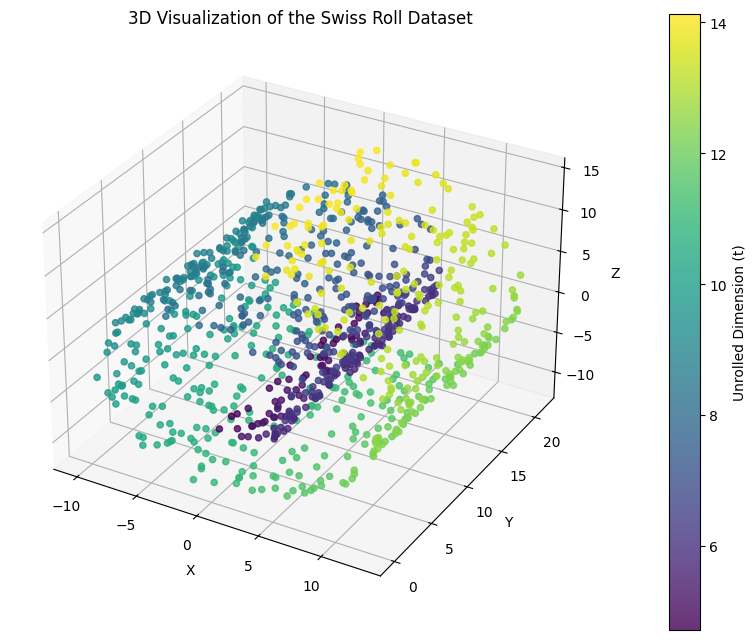

In [35]:
create_3d_figure(X_swiss_Ujjwal_df)

In [36]:
@dataclass
class Pca_ouput:
    kpca_linear: np.ndarray
    kpca_rbf: np.ndarray
    kpca_sigmoid: np.ndarray

In [37]:
def apply_kernal_pca(X: pd.DataFrame) -> Pca_ouput:
    """ 
    Applys three different types of kernal, linear, rbf and sigmoid

    Args:
        X (pd.DataFrame): Feature set to apply pcs

    Returns:
        Pca_output: It return three object will linear, rbf and sigmoid applied array
    """

    # Applying Linear Kernel PCA
    kpca_linear = KernelPCA(n_components=2, kernel='linear')
    X_kpca_linear = kpca_linear.fit_transform(X)\

    # Applying RBF Kernel PCA
    kpca_rbf = KernelPCA(n_components=2, kernel='rbf', gamma=0.002)
    X_kpca_rbf = kpca_rbf.fit_transform(X)

    # Applying Sigmoid Kernel PCA
    kpca_sigmoid = KernelPCA(n_components=2, kernel='sigmoid', gamma=0.002, coef0=1)
    X_kpca_sigmoid = kpca_sigmoid.fit_transform(X)  

    return Pca_ouput(kpca_linear=X_kpca_linear, kpca_rbf=X_kpca_rbf, kpca_sigmoid=X_kpca_sigmoid)

In [31]:
kernal_pca = apply_kernal_pca(X_swiss_Ujjwal)

# Prints the shapes of the results to confirm
print("\nOriginal data shape:", X_swiss_Ujjwal.shape)
print("Shape after Linear Kernel PCA:", np.shape(kernal_pca.kpca_linear))
print("Shape after RBF Kernel PCA:", np.shape(kernal_pca.kpca_rbf))
print("Shape after Sigmoid Kernel PCA:", np.shape(kernal_pca.kpca_sigmoid))


Original data shape: (1000, 3)
Shape after Linear Kernel PCA: (1000, 2)
Shape after RBF Kernel PCA: (1000, 2)
Shape after Sigmoid Kernel PCA: (1000, 2)


In [41]:
def create_2d_plot(kernal: Pca_ouput, color: np.ndarray):
    """ 
    Creates 2d plot for all the kernals

    Args:
        kernal (Pca_output): An object that contains all the array of the kernal pca
        color (np.ndarray): An array containing the color value
    """

    # Creating the plots
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle('Kernel PCA with Different Kernels', fontsize=16)

    # Linear Kernel Plot
    axes[0].scatter(kernal.kpca_linear[:, 0], kernal.kpca_linear[:, 1], c=color, cmap='viridis')
    axes[0].set_title('Linear Kernel')
    axes[0].set_xlabel('1st Principal Component')
    axes[0].set_ylabel('2nd Principal Component')

    # RBF Kernel Plot
    axes[1].scatter(kernal.kpca_rbf[:, 0],kernal.kpca_rbf[:, 1], c=color, cmap='viridis')
    axes[1].set_title('RBF Kernel')
    axes[1].set_xlabel('1st Principal Component')

    # Sigmoid Kernel Plot
    axes[2].scatter(kernal.kpca_sigmoid[:, 0], kernal.kpca_sigmoid[:, 1], c=color, cmap='viridis')
    axes[2].set_title('Sigmoid Kernel')
    axes[2].set_xlabel('1st Principal Component')

    plt.show()

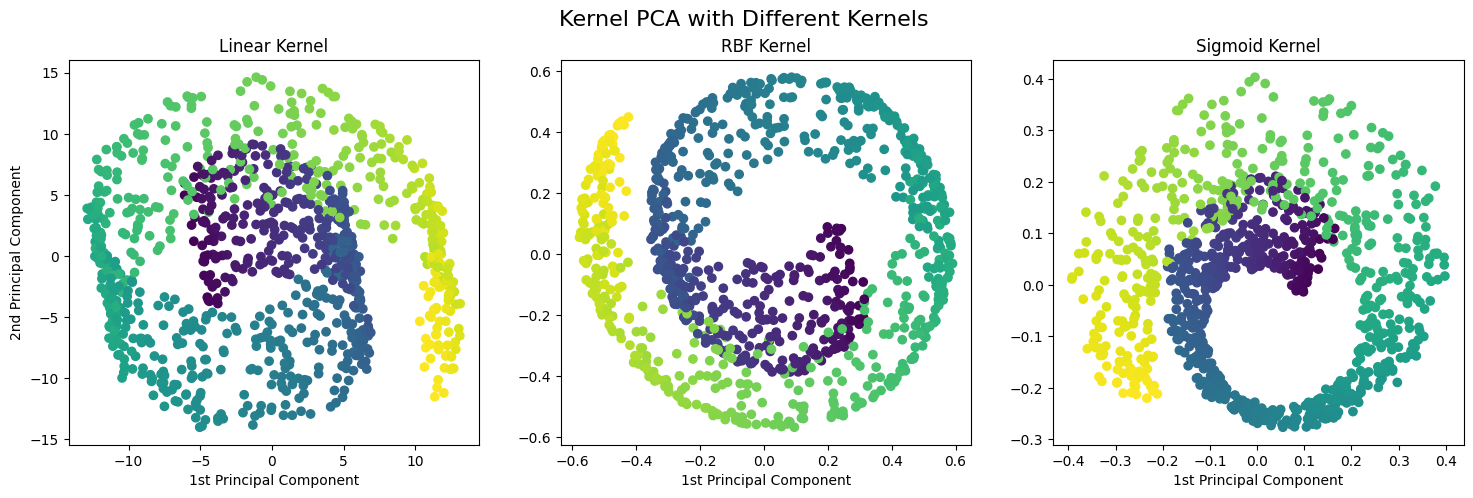

In [42]:
create_2d_plot(kernal_pca, color=color)

In [ ]:
def find_best_kpca_model(X: pd.DataFrame, y: np.ndarray) -> GridSearchCV:
    """ 
    Perform grid search on dataset, with rbf and sigmoid kernal and logistic regression.

    Args:
        X (pd.DataFrame): The features dataframe, original
        y (np.ndarray): The label after making it binary
    """

    # Creating the pipleline with KernelPCA and logistic regression
    pipeline = Pipeline([
        ('kpca', KernelPCA(n_components=2)),
        ('log_reg', LogisticRegression())
    ])

    # Creating parameters for grid search
    param_grid = [{
        'kpca__kernel': ['rbf', 'sigmoid'],
        'kpca__gamma': [0.001, 0.002, 0.005, 0.01]
    }]

    # Initilizing the grid search
    grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy')

    # Fitting the data
    grid_search.fit(X, y)
    
    return grid_search

In [46]:
# Creating the lables
y = color > 6.9

# Grid search call
best_model_search = find_best_kpca_model(X_swiss_Ujjwal, y)

In [47]:
print("\nBest parameters found by GridSearchCV:")
print(best_model_search.best_params_)
print(f"\nBest cross-validation accuracy: {best_model_search.best_score_:.4f}")


Best parameters found by GridSearchCV:
{'kpca__gamma': 0.01, 'kpca__kernel': 'rbf'}

Best cross-validation accuracy: 0.7830


In [49]:
def apply_best_kpca(X: pd.DataFrame, best_model_search: GridSearchCV) -> np.ndarray:
    """ 
    Extracts the fitted kPCA model from the best pipeline and transforms the data.

    Args:
        X (pd.DataFrame): The data to transform.
        best_model_search (GridSearchCV): The already fitted GridSearchCV object.

    Returns:
        The data transformed into 2D by the best kPCA model.
    """

    # Getting the entire best pipeline (kpca + logistic regression)
    best_pipeline = best_model_search.best_estimator_

    # Accessing just the fitted 'kpca' step by its name
    best_kpca_model = best_pipeline.named_steps['kpca']

    # Using just the kpca model to transform the data
    X_transformed = best_kpca_model.transform(X)

    return X_transformed

In [50]:
best_transformed_kpca = apply_best_kpca(X_swiss_Ujjwal, best_model_search)

In [51]:
print(np.shape(best_transformed_kpca))

(1000, 2)


In [52]:
def plot_2d_projection(X: np.ndarray, color: np.ndarray):
    """ 
    Creates 2d plot for two Principle component using color

    Args:
        X (np.ndarray): Array with appled PCA
        color (np.ndarray): Array with defined color for the PCA
    """

    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=color, cmap='viridis')
    plt.title('2D Projection using Best Kernel (RBF, gamma=0.002)')
    plt.xlabel('1st Principal Component')
    plt.ylabel('2nd Principal Component')
    plt.colorbar(label='Class (t > 6.9)')
    plt.grid(True)
    plt.show()

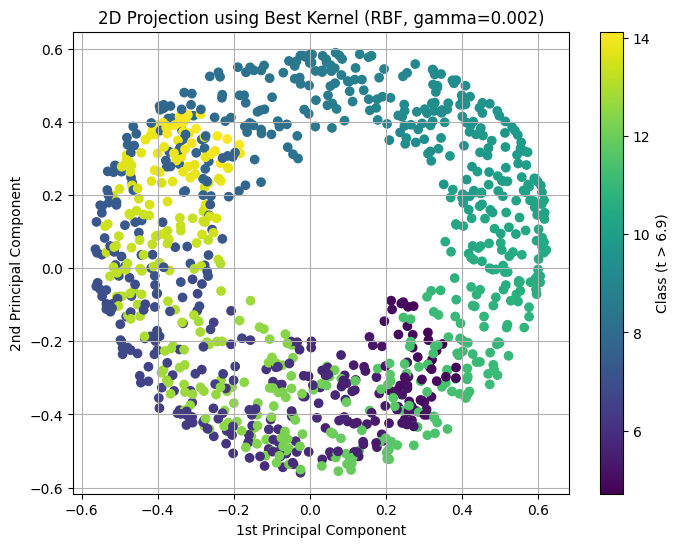

In [53]:
plot_2d_projection(X=best_transformed_kpca, color=color)